In [3]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]


In [6]:
root = "/Users/mac/Documents/R_D/COM_VIS/Les16/"
input_dir = os.path.join(root, "images")
target_dir = os.path.join(root, "annotations/trimaps/")
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = [f for f in os.listdir(input_dir) if f.endswith(".jpg")]
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in input_img_paths])

target_img_paths = [f for f in os.listdir(target_dir) if f.endswith(".png") and not f.startswith(".")]
target_img_paths = sorted([os.path.join(target_dir, f) for f in target_img_paths])

assert len(input_img_paths) == len(target_img_paths)
print("Number of samples:", len(input_img_paths))


Number of samples: 7390


(175, 250, 3)


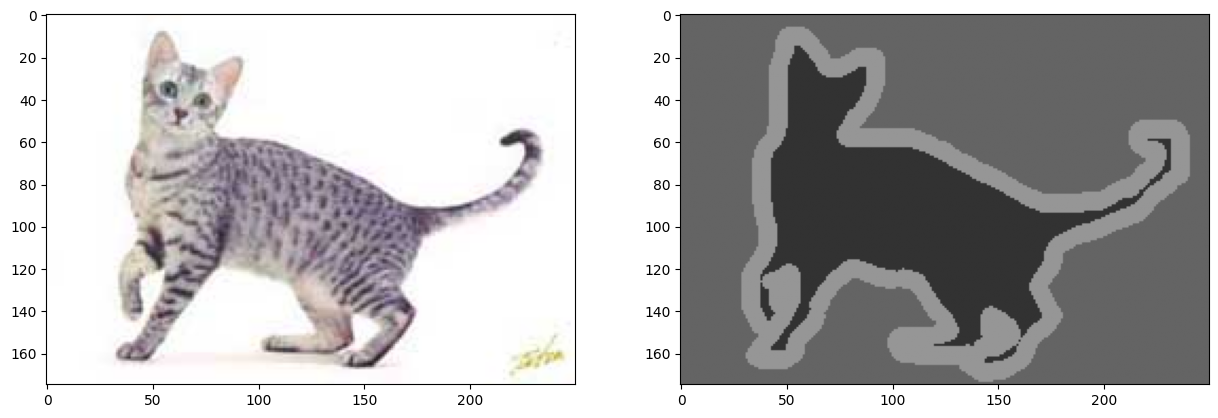

In [7]:
idx = 1000

img = cv2.cvtColor(cv2.imread(input_img_paths[idx]), cv2.COLOR_BGR2RGB)
mask = cv2.imread(target_img_paths[idx])

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(mask/255*50)

print(mask.shape)

In [8]:
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 80, 80,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 80, 80,    │     18,496 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 80, 80,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 40, 40,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 40, 40,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 40, 40,    │     73,856 │ activation_3[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 3,085,123 (11.77 MB)

 Trainable params: 3,081,347 (11.75 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [9]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [10]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle

class OxfordPets(keras.utils.Sequence):    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to **batch** index."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
            
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
            
        return x/255, y
    
    def on_epoch_end(self):
        self.input_img_paths, self.target_img_paths = shuffle(self.input_img_paths, self.target_img_paths)

In [11]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

# Split data
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data generators
train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [15]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)]


In [16]:

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/199 ━━━━━━━━━━━━━━━━━━━━ 558s 3s/step - loss: 2.3571 - val_loss: 0.7150
Epoch 2/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 555s 3s/step - loss: 0.5504 - val_loss: 0.5733
Epoch 3/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step - loss: 0.4567 - val_loss: 0.4904
Epoch 4/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 553s 3s/step - loss: 0.3917 - val_loss: 0.3845
Epoch 5/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 554s 3s/step - loss: 0.3540 - val_loss: 0.3886
Epoch 6/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - loss: 0.3226 - val_loss: 0.4805
Epoch 7/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - loss: 0.2990 - val_loss: 0.3391
Epoch 8/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - loss: 0.2755 - val_loss: 0.3467
Epoch 9/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - loss: 0.2639 - val_loss: 0.3344
Epoch 10/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - loss: 0.2443 - val_loss: 0.3443
Epoch 11/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 546s 3s/step - loss: 0.2303 - val_loss: 0.3186
Epoch 12/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/ste

In [19]:
# Generate predictions for all images in the validation set
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 690ms/step


(<Axes: >, <matplotlib.image.AxesImage at 0x1584137a0>)

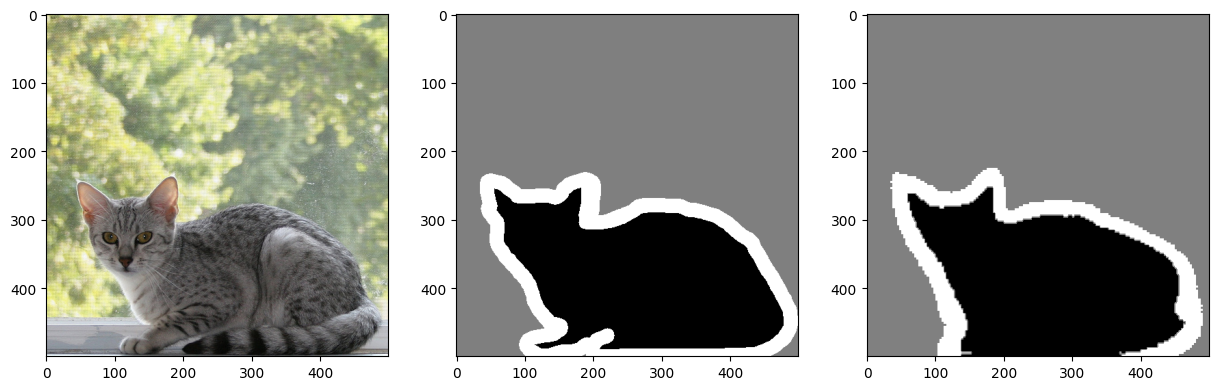

In [20]:
idx = 20

mask = np.argmax(val_preds[idx], axis=-1)
mask = np.expand_dims(mask, axis=-1)

x = load_img(val_input_img_paths[idx])
y_true = load_img(val_target_img_paths[idx])
y_true = (np.array(y_true) - 1.0)/2

rows, cols, _ = y_true.shape
mask = cv2.resize(mask.astype(np.uint8), (cols, rows))

plt.subplot(131), plt.imshow(x)
plt.subplot(132), plt.imshow(y_true)
plt.subplot(133), plt.imshow(mask, cmap='gray')